# Deep calibration of the stochastic local Heston Model

This second part builds partially on the local volatility calibration method developed in https://nbviewer.jupyter.org/url/people.math.ethz.ch/~jteichma/lecture_ml_web/local_stoch_vol_calibration.ipynb and https://nbviewer.jupyter.org/url/people.math.ethz.ch/~jteichma/lecture_ml_web/heston_calibration.ipynb. Different to those, here a SLV-model is calibrated where the stochastic part is given by the Heston model, see notebook `SLV-calib-stochastic.ipynb`.

Consider the model
\begin{equation}
\begin{cases}
d S_t = \big( r - d \big) S_t dt + \sqrt{\nu_t} L(t, S_t) S_tdW_t^S \\
d\nu_t = \kappa \big( \theta - \nu_t \big) dt + \sigma \sqrt{\nu_t} dW_t^\nu \\
dW_t^S  dW_t^\nu = \rho dt \,.
\end{cases}
\end{equation}
with initial value $ S_0 $. $r,d$ are the risk-free interest and dividend rate. The parameters $\kappa,\theta,\sigma,\rho$ of the stochastic Heston model describe the mean reversion speed, the long time variance, the vol of vol and the correlation between the Wiener processes $dW_t^S, dW_t^\nu$, respectively. The function $L$ is called \textit{leverage function} and represents the local part of the stochastic local volatility model. The leverage function is modeled by $L(t,S_t) = 1 + \mathcal{N}(t,S_t)$, with function $N$ given in terms of a neural network.

The parameters of the stochastic part (Heston) are obtained in the first calibration step described in the other notebook. The network $N$ can be learned by fitting the expected payoff of a set of European call options with strike $K$ and maturity $T$ to observed market prices $P_\text{market}(T,K)$ of these options:
$$
\sum_{(K,T)} \Big| E\big[(S_T-K)_+\big] - P_{\text{market}}(T,K) \Big|^2 \rightarrow \text{min!}
$$
Notice that the sum is running over a finite set of price data points. The calibration to price surfaces instead of implied volatilities is more naturally implemented by means of a neural network, as described in more detail in the documentation `deep_calibration_SLV_model.pdf`.

In [1]:
# Import packages
from __future__ import division
import time
import pandas as pd
import numpy as np
import datetime as dt
import math

import QuantLib as ql
# This controls whether functionEvaluation is available in QuantLib library
has_function_evals = True
float_type = np.float32

from itertools import product
import matplotlib.pyplot as plt
from scipy.stats import norm
import pickle
import os
data_dir = os.getcwd()

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras import Sequential
#from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv2D, Concatenate, Dropout, Subtract, Flatten, MaxPooling2D, Multiply, Lambda, Add, dot, Activation, BatchNormalization, Input
from tensorflow.keras.backend import constant
from tensorflow.keras import optimizers

from tensorflow.keras.layers import Layer
#from keras.engine.topology import Layer
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm
import tensorflow.keras.backend as K
#import keras.backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

Note that eager execution has to be disabled.

In [2]:
# Calendar conventions
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
# Option conventions
moneyness = [.8, .85, .9, .95, .98, .99, 1.0, 1.01, 1.02, 1.05, 1.1, 1.15, 1.2] # S_0/K 
delta_times = [15, 30, 45, 60, 90, 120, 180, 240, 300, 360, 420]


'''
Dictionary defining model
It requires 3 parameters:
    -name
    -process
    -model: a function that creates a model. It takes as parameter a 
            yield curve handle
    -engine: a function that creates an engine. It takes as paramters a
            calibration model and a yield curve handle
    -option_type            
Optional parameters:
    -transformation: a preprocessing function
    -inverse_transformation: a postprocessing function
'''
he_analytic = {'name' : 'Heston',
               'process' : ql.HestonProcess,
               'model' : ql.HestonModel, 
               'engine' : ql.AnalyticHestonEngine,
               'option_type' : ql.Option.Call,
               'transformation' : np.log, 
               'inverse_transformation' : np.exp}


# Helper functions
def create_imp_vol_skeleton(strike_struct, expiration_dates_struct, 
                            calculation_date, spot_price):
    '''
    Create the structure (skeleton) on which it is possible to price all options.
    '''
    strikes = [spot_price/m for m in strike_struct]
    expiries = [calculation_date+d_time for d_time in expiration_dates_struct]
    ttm_days = [(d-calculation_date) for d in expiries] # time to maturity
    ttm_year = [day_count.yearFraction(calculation_date, d) for d in expiries]
    
    new_array = np.array((ttm_days,strikes))
    cartesian_product_vola_surface = list(product(*new_array))
    df = pd.DataFrame(cartesian_product_vola_surface, 
                        columns=['ttm','strikes'])
    return strikes, np.array((ttm_year)), expiries, df

def set_risk_free_rate(calculation_date, risk_free_rate):
    return ql.YieldTermStructureHandle(
            ql.FlatForward(calculation_date,risk_free_rate,day_count))

def set_dividend_rate(calculation_date, dividend_rate):
    return ql.YieldTermStructureHandle(
            ql.FlatForward(calculation_date,dividend_rate,day_count))

def set_spot(spot_price):
    return ql.QuoteHandle(ql.SimpleQuote(spot_price))

def create_european_option(calculation_date, opt_type, strike_price, ttm):
    # Create European options
    payoff = ql.PlainVanillaPayoff(opt_type, strike_price)
    maturity = calculation_date+int(ttm)
    exercise = ql.EuropeanExercise(maturity)
    return ql.VanillaOption(payoff, exercise)


class Heston_Model:
    def __init__(self, model_dict, spot_price=100., risk_free_rate=0.01, dividend_rate=0.0,
                 inst_var=0.1, calculation_date=ql.Date(8,11,2015),  
                 expiration_dates_struct=delta_times, strike_struct=moneyness,
                 mean_rev_speed=None, eq_var=None, vol_of_vol=None, correlation=None):
        '''
        This class implements the Heston model for a series of given parameters.
        The output will be a dataframe where the columns are parameters, strikes
        time_to_maturities, prices and values of the volatility surface.
        '''
        self._model_dict = model_dict
        if ('process' not in self._model_dict 
            or 'model' not in self._model_dict
            or 'engine' not in self._model_dict
            or 'name' not in self._model_dict
            or 'option_type' not in self._model_dict):
            raise RuntimeError('Missing parameters in the dictionary')
        
        self.option_type = self._model_dict['option_type']
        self.calculation_date = calculation_date
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        #heston model parameters
        self.nb_params = 4
        self.sigma = vol_of_vol
        self.rho = correlation
        self.theta = eq_var
        self.kappa = mean_rev_speed
        self.heston_param = np.array((self.kappa,self.theta,self.sigma,self.rho))
        
        # volatility surface structure
        self.strikes, self.ttm, self.expiries, self.df = create_imp_vol_skeleton(
                                    strike_struct, expiration_dates_struct, 
                                    calculation_date, spot_price)
        
        # Yield curve, dividends, spot and instantaneous volatility
        self.risk_free_rate = risk_free_rate
        self.dividend_rate = dividend_rate
        self.spot_price = spot_price
        self.v0 = inst_var
        
        self.ircurve = set_risk_free_rate(self.calculation_date, self.risk_free_rate)
        self.dividend = set_dividend_rate(self.calculation_date, self.dividend_rate)
        self.spot = set_spot(self.spot_price)
        
        process = self.__create_process(self.kappa,self.theta,self.sigma,self.rho)
        model = self._model_dict['model'](process)
        engine = self._model_dict['engine'](model)
        
        eu_options = [create_european_option(self.calculation_date,self.option_type,s,t) 
                   for s,t in zip(self.df['strikes'], self.df['ttm'])]
        [opt.setPricingEngine(engine) for opt in eu_options]
        self.df['price'] = [o.NPV() for o in eu_options]
#        self.df['analytical_price'] = self.df['price'][:] #####

    def __create_process(self,kappa,theta,sigma,rho):
        # Creation of the object Process
        return self._model_dict['process'](self.ircurve,self.dividend,self.spot,
                self.v0,kappa,theta,sigma,rho)
    
# Helper functions for the class HestonGroup
def datetime_to_ql(d):
    return ql.Date(d.day,d.month,d.year)



def ql_to_datetime(dateql):
    return dt.datetime(dateql.year(), dateql.month(), dateql.dayOfMonth())

def ql_to_datetime_settings_dict(dates_ql, dictionary):
    if bool(dictionary):
        for dateql in dates_ql:
            helper = ql_to_datetime(dateql)
            dictionary[helper]=dictionary.pop(dateql)                                                                
                
def datetime_to_ql_settings_dict(dates, dictionary):
    if bool(dictionary):
        dates = sorted(dates)
        for date in dates:
            helper = date_to_ql(date)
            dictionary[helper] = dictionary.pop(date)
            
def save_dictionary(dictionary, name_dict, path=data_dir):
        filehandler = open(path+ '/' +name_dict+'.pkl','wb')
        pickle.dump(dictionary,filehandler)
        filehandler.close()

def load_dictionary(name_dict, path=data_dir):
        with open(path+ '/' +name_dict+'.pkl', 'rb') as handle:
            dictionary = pickle.load(handle)
        return dictionary
    
# Bounds for the calibration of the parameters (in implied_vola_generation.py)
he_generation_bounds = [(0.5,10.), (0.05,0.8), (0.05,0.8), (-0.99,0.99)] #kappa,theta,sigma,rho
he_calibration_bounds = [(0.001,15.), (0.001,6.), (0.005,4.), (-0.999,0.999)]
he_mean_as_initial_point = [5., 1.5, 1., 0.]

# Function to plot the volatility surface
def plot_surface(Z, z_label, main_title, string1='', string2='', W=None, string3='', **kwargs):
    times = kwargs.get('delta_times', delta_times)
    money = kwargs.get('moneyness', moneyness)
    X = times; Y = money
    X, Y = np.meshgrid(X, Y)
    X = np.transpose(X); Y = np.transpose(Y)
    if Z.shape != (X.shape[0],Y.shape[1]):
        Z = Z.reshape((len(times),len(money)))
    if W is not None and W.shape != (X.shape[0],Y.shape[1]):
        W = W.reshape((len(times),len(money)))
    
    if W is None:
        from mpl_toolkits.mplot3d import Axes3D
        from matplotlib import cm
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.colorbar(surf, shrink=0.6, aspect=20, ax=ax)
        ax.set_xlabel('time to maturity (days)'); ax.set_ylabel('moneyness (%)'); ax.set_zlabel(z_label)
        ax.text2D(0.06, 0.98, string1, transform=ax.transAxes)
        ax.text2D(0.06, 0.94, string2, transform=ax.transAxes)
        fig.suptitle(main_title)
        plt.show()
    else:
# COMMENT IF MAYAVI NOT AVAILABLE
#        from mayavi import mlab
#        fig = mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), size=(1200,600))
#        ax_ranges = [min(times), max(times), min(money), max(money), 0, max(np.amax(Z),np.amax(W))]
#        surf3 = mlab.surf(X, Y, Z, colormap='Oranges', warp_scale='auto')
#        surf4 = mlab.surf(X, Y, W, colormap='Blues', warp_scale='auto')
#        cb1 = mlab.colorbar(object=surf3, title='Original IVS', orientation='vertical', nb_labels=5, nb_colors=None, label_fmt=None)#Original
#        cb2 = mlab.colorbar(object=surf4, title='Neural net 1', orientation='vertical', nb_labels=5, nb_colors=None, label_fmt=None)#NN1
#        cb1.scalar_bar_representation.position = [0.12, 0.15] #bottom left
#        cb1.scalar_bar_representation.position2 = [0.1, 0.8] # from position!!!
#        cb2.scalar_bar_representation.position = [0.01, 0.15] #bottom left
#        cb2.scalar_bar_representation.position2 = [0.1, 0.8]
##        mlab.view(60, 74, 17, [-2.5, -4.6, -0.3])
#        ax = mlab.axes(surf3, color=(.7, .7, .7), #extent=ax_extent,
#                       ranges=ax_ranges, xlabel='time to maturity (days)', 
#                       ylabel='moneyness (%)', zlabel=z_label, nb_labels=5)
#        ax.axes.font_factor=0.8
#        title = mlab.title(main_title)
#        title.x_position = 0.3
#        title.y_position = 0.8
#        title.width = 0.5
#        print(title.__dict__)
#        mlab.show()
# UNCOMMENT IF MAYAVI NOT AVAILABLE        
        from mpl_toolkits.mplot3d import Axes3D
        from matplotlib import cm
        fig = plt.figure()
        fig.set_figheight(8)
        fig.set_figwidth(16)
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        surf1 = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        fig.colorbar(surf1, shrink=0.6, aspect=20, ax=ax)
        ax.set_xlabel('time to maturity (days)'); ax.set_ylabel('moneyness (%)'); ax.set_zlabel(z_label)
        ax.text2D(0.06, 0.98, string1, transform=ax.transAxes)
        ax.text2D(0.06, 0.94, string2, transform=ax.transAxes)
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        surf1 = ax.plot_surface(X, Y, Z, cmap=cm.Oranges, linewidth=0, antialiased=True, alpha=0.2)
        surf2 = ax.plot_surface(X, Y, W, cmap=cm.Blues, linewidth=0, antialiased=True)
        fig.colorbar(surf1, shrink=0.6, aspect=20, ax=ax)
        fig.colorbar(surf2, shrink=0.6, aspect=20, ax=ax)
        ax.text2D(0.15, 0.96, string3, transform=ax.transAxes)
        ax.set_xlabel('time to maturity (days)'); ax.set_ylabel('moneyness (%)'); ax.set_zlabel(z_label)
        fig.suptitle(main_title)
        plt.show()
    return fig
        
        
        
'''
 - Search for the implied volatility - 
Since the differential evolution algorithm is extremly long, I have to use
another method to derive the implied volatility for option prices.
References are Li and Lee (2011) and Stefanica and Radoicic (2017).
'''

def approx_func(x):
    return 0.5 + 0.5*np.sign(x)*np.sqrt(1. - np.exp(-2.*(x**2)/np.pi))

def guess_StefanicaRadoicic(option_type, strike, option_price, spot_price,
                            ir_discount, dr_discount):
    
    forward = spot_price * dr_discount / ir_discount
    ey = forward/strike #ey=exp(y)
    emy = strike/forward #emy=exp(-y)
    y = np.log(ey) #(simple) log moneyness
    alpha = option_price/(strike*ir_discount)
    
    if option_type==1:
        #Call
        R = 2.*alpha - ey + 1.
    else:
        #Put
        R = 2.*alpha + ey - 1.
    pi_term = 2./np.pi
    arg_exp_term = (1.-pi_term)*y
    R2 = R**2
    
    a = np.exp(arg_exp_term)
    A = (a - 1./a)**2
    b = np.exp(pi_term*y)
    B = 4.*(b + 1./b) - 2.*emy*(a + 1./a)*(ey**2 + 1. - R2)
    C = (emy**2) * (R2 - (ey - 1.)**2) * ((ey + 1.)**2 - R2)
    beta = 2.*C / (B + np.sqrt(B**2 + 4.*A*C))
    gamma = - np.pi/2.*np.log(beta)    
    
    if y>=0.:
        if option_type==1: #call
            O0 = strike*ir_discount*(ey*approx_func(np.sqrt(2.*y)) - 0.5)
        else:
            O0 = strike*ir_discount*(0.5 - ey*approx_func(-np.sqrt(2.*y)))
        if option_price <= O0:
            nu = np.sqrt(gamma+y) - np.sqrt(gamma-y)
        else:
            nu = np.sqrt(gamma+y) + np.sqrt(gamma-y)
    else:
        if option_type==1: #call
            O0 = strike*ir_discount*(0.5*ey - approx_func(-np.sqrt(-2.*y)))
        else:
            O0 = strike*ir_discount*(approx_func(np.sqrt(-2.*y)) - 0.5*ey)
        if option_price <= O0:
            nu = np.sqrt(gamma-y) - np.sqrt(gamma+y)
        else:
            nu = np.sqrt(gamma+y) + np.sqrt(gamma-y)
    return nu

def Phi(x,nu):
    nu2 = nu**2
    abs_term = 2.*np.abs(x)
    return (nu2-abs_term)/(nu2+abs_term)
def N_plus(x,nu):
    return norm.cdf(x/nu + 0.5*nu)
def N_minus(x,nu):
    return np.exp(-x)*norm.cdf(x/nu - 0.5*nu)
def F(nu, x, c_star, omega):
    return c_star + N_minus(x,nu) + omega*N_plus(x,nu)
def G(nu, x, c_star, omega):
    argument = F(nu, x, c_star, omega)/(1.+omega)
    term = norm.ppf(argument)
    return term + np.sqrt(term**2 + 2.*np.abs(x))
    
def SOR_TS(option_type, strike, discount_ir, discount_dr, option_price, 
                     spot_price, guess, omega, accuracy, max_iterations=20):
    
    # assert (option_price >= 0.),'Price must be positive.'
    
    forward = spot_price * discount_dr / discount_ir
    x = np.log(forward/strike) #(simple) log moneyness
    
    if option_type==1:  #call
        c = option_price/(spot_price*discount_dr)
    else:   #put
        c = option_price/(spot_price*discount_dr) + 1. - strike/forward
    
    if x > 0.:
        # formula in-out duality
        c = c*forward/strike + 1. - forward/strike
        assert (c >= 0.),'Normalized price must be positive.'
        x = -x
    
    if not guess:
        guess = guess_StefanicaRadoicic(option_type, strike, option_price, 
                                       spot_price, discount_ir, discount_dr)
    assert (guess >= 0.),'Initial guess must be positive.'
    
    nIter = 0
    nu_k = nu_kp1 = guess
    difference = 1.
    while (np.abs(difference)>accuracy and nIter<max_iterations):
        nu_k = nu_kp1
        alpha_k = (1.+omega)/(1.+Phi(x,nu_k))
        nu_kp1 = alpha_k*G(nu_k, x, c, omega) + (1.-alpha_k)*nu_k
        difference = nu_kp1 - nu_k
        nIter +=1
    return nu_kp1

def return_year_fraction(date, ttm):
    return [day_count.yearFraction(date,date+int(nd)) for nd in ttm]

class VolaSurface:
    '''
    This class takes in input some prices and transform them in a volatility surface.
    '''
    def __init__(self, option_type, spot_price=100, risk_free_rate=0.01, dividend_rate=0.0,
                 calculation_date=ql.Date(8,11,2015), df=None):   
        # Main data structure
        self.data = df

        # Check to see if there are the correct columns        
        if not 'ttm' in self.data.columns \
        or not 'strikes' in self.data.columns \
        or not 'price' in self.data.columns:
            raise RuntimeError('Some necessary data is missing')
        
        # Option type, calculation date
        self.option_type = option_type
        self.calculation_date = calculation_date #already a ql Date
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        # Yield curve, dividends, spot
        self.ircurve = set_risk_free_rate(self.calculation_date, risk_free_rate)
        self.dividend = set_dividend_rate(self.calculation_date, dividend_rate)
        self.spot = set_spot(spot_price)
        
        # Tolerance on implied volatility error
        self.tol = 1.e-14
    

    def __implied_vola(self, price, strike, ttm):
        # Find the implied volatility through other algorithms
        discount_ir = self.ircurve.discount(self.calculation_date+int(ttm))
        discount_dr = self.dividend.discount(self.calculation_date+int(ttm))
        sol = 0.0
        try:
            sol = SOR_TS(self.option_type, strike, discount_ir, discount_dr,
                         price, self.spot.value(), guess=None, 
                         omega=1., accuracy=self.tol)
        except (RuntimeWarning, AssertionError) as e:
            print(repr(e))
        yearly_ttm = day_count.yearFraction(self.calculation_date, self.calculation_date+int(ttm))
        sol = sol/np.sqrt(yearly_ttm)
        return sol
        
        
    def get_implied_vola(self):
        ivs = []
        for i in range(len(self.data['price'])):
            ivs.append(self.__implied_vola(self.data['price'][i],
                                           self.data['strikes'][i],
                                           self.data['ttm'][i]) + 1.E-5) #regularization
            if ivs[i]==0.:
                raise ValueError('Zero implied volatility!')
        return ivs
    
    
class HestonGroup:
    
    def __init__(self, model_dict=he_analytic, first_date=ql.Date(1,1,2018), 
                 end_date=ql.Date(2,1,2018)):
        #Create a collection of object of type Heston_Model
        self._model_dict = model_dict
        if ('model' not in self._model_dict
            or 'process' not in self._model_dict
            or 'engine' not in self._model_dict 
            or 'name' not in self._model_dict 
            or 'option_type' not in self._model_dict):
            raise RuntimeError('Missing parameters in the dictionary')
        self.model_name = self._model_dict['name'].replace("/", "").lower()
        
        # Option type
        self.option_type = self._model_dict['option_type']
        # Dates
        self.dates = pd.date_range(ql_to_datetime(first_date), ql_to_datetime(end_date))
        #print(self.dates)
        # in this way I generate a date for every day (with holidays)
        self.dates_ql = [datetime_to_ql(d) for d in self.dates]
        #print(self.dates_ql)
        
        # Dictionaries
        self.he_observable = {} #contains s0, ir, dr and v0
        self.he_hist_parameters = {} #contains s0, ir, dr + 5 heston params
        self.he_hist_df = {} #contains the entire data_frame with ttm, strikes, prices
        self.he_hist_iv = {} #contains the implied vola surface given by the data_frame
        
        
    # Methods for the generation of the fake volatility surfaces
    def __generate_ir(self):
        return np.clip(np.random.beta(a=1.01, b=60), 0.001, 0.08)
    def __generate_dr(self):
        return np.clip(np.random.beta(a=1.01, b=60), 0.001, 0.03)
    def __generate_sp(self):
        return 100*(np.random.beta(a=8, b=8) + 1.0E-2)
    def __generate_theta(self):
        return np.random.uniform(low=he_generation_bounds[1][0], high=he_generation_bounds[1][1])
    def __generate_v0(self):
        return np.random.uniform(low=0.001, high=0.9)**2
    def __generate_rho(self):
        return np.random.uniform(low=he_generation_bounds[3][0], high=he_generation_bounds[3][1])
    def __generate_kappa(self):
        return np.random.uniform(low=he_generation_bounds[0][0], high=he_generation_bounds[0][1])
    def __generate_sigma(self):
        return np.random.uniform(low=he_generation_bounds[2][0], high=he_generation_bounds[2][1])

    def create_Heston_model(self, date, **kwargs):
        '''
        Use fake (random) datas to create the data structure for the Heston model
        and the volatility surface.
        '''
        ir = kwargs.get('ir', self.__generate_ir())
        dr = kwargs.get('dr', self.__generate_dr())
        sp = kwargs.get('sp', self.__generate_sp())
        v0 = kwargs.get('v0', self.__generate_v0())
        rho = kwargs.get('rho', self.__generate_rho())
        sigma = kwargs.get('sigma', self.__generate_sigma()) #vol of vol! Not implied vola!
        # Loop until the Feller condition is satisfied
        theta = kwargs.get('theta', self.__generate_theta())
        kappa = kwargs.get('kappa', self.__generate_kappa())
        while 2*kappa*theta <= sigma**2:
            theta = self.__generate_theta()
            kappa = self.__generate_kappa()
        
        return Heston_Model(model_dict=he_analytic, spot_price=sp, risk_free_rate=ir,
                            dividend_rate=dr, calculation_date=date, 
                            expiration_dates_struct=delta_times, 
                            strike_struct=moneyness, vol_of_vol=sigma, 
                            correlation=rho, eq_var=theta, inst_var=v0, 
                            mean_rev_speed=kappa)
    
    
    def show_ivs(self, **kwargs):
        '''
        Plot implied volatility surface
        '''
        rd = self.dates_ql[0]
        hest_obj = self.create_Heston_model(date = rd, **kwargs)
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=0.09,rho=-0.75,kappa=1,theta=0.06,sigma=0.4)
#        https://hpcquantlib.wordpress.com/2016/09/11/the-collocating-local-volatility-model/
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=1,rho=-0.9,kappa=5.7,theta=1,sigma=0.1)
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=0.5**2,rho=0.5,kappa=6.2,theta=0.4**2,sigma=0.8)
#        hest_obj = self.create_Heston_model(date=rd,sp=100,ir=0.1,dr=0.05,v0=0.4**2,rho=-0.1,kappa=1.5,theta=0.9**2,sigma=0.8)
        obs_str = [r'$S_0 = $', r'$r = $', r'$d = $', r'$\nu_0 = $']
        obs = [hest_obj.spot_price, hest_obj.risk_free_rate,
               hest_obj.dividend_rate, hest_obj.v0]
        obs_str = ["{}{:.6}".format(o, str(v)) for o,v in zip(obs_str, obs)]
        params_str = [r'$\kappa = $', r'$\theta = $', r'$\sigma = $', r'$\rho = $']
        params = [hest_obj.kappa,hest_obj.theta, hest_obj.sigma, hest_obj.rho]
        params_str = ["{}{:.5}".format(o, str(v)) for o,v in zip(params_str, params)]
        df = hest_obj.df
        ivs = VolaSurface(option_type=hest_obj.option_type, 
                          spot_price=hest_obj.spot_price, 
                          risk_free_rate=hest_obj.risk_free_rate, 
                          dividend_rate=hest_obj.dividend_rate,
                          calculation_date=hest_obj.calculation_date, 
                          df=hest_obj.df).get_implied_vola()
        plot_surface(Z=np.array(ivs), z_label='ivs', 
                     main_title='Heston Imp Vola Surface',
                     string1=', '.join(o for o in obs_str), 
                     string2=', '.join(p for p in params_str))
#         return np.array(ivs), df
    
    
    def create_historical_process_data(self, **kwargs):
        '''
        Real creation of Heston data: big loop over all dates.
        '''
        k = 0
        while k<len(self.dates_ql):
            datehelper = self.dates_ql[k]
            try:
                print('Date: ',datehelper)
                hest_obj = self.create_Heston_model(datehelper)
                self.he_observable[datehelper] = np.array((hest_obj.spot_price,hest_obj.risk_free_rate,
                               hest_obj.dividend_rate,hest_obj.v0))
                self.he_hist_parameters[datehelper] = np.array((hest_obj.kappa,hest_obj.theta,
                                                          hest_obj.sigma,hest_obj.rho))
                print('Parameters: ',np.array((hest_obj.kappa,hest_obj.theta,
                                                          hest_obj.sigma,hest_obj.rho)))
                self.he_hist_df[datehelper] = hest_obj.df
                ivs = VolaSurface(option_type=hest_obj.option_type, 
                                  spot_price=hest_obj.spot_price, 
                                  risk_free_rate=hest_obj.risk_free_rate, 
                                  dividend_rate=hest_obj.dividend_rate,
                                  calculation_date=hest_obj.calculation_date, 
                                  df=hest_obj.df)
                self.he_hist_iv[datehelper] = ivs.get_implied_vola()
            except (ValueError) as e:    
                print(e)
            else:
                k += 1
        
        if 'file_name' in kwargs and kwargs['file_name'] !='': #needed for manual parallelization
            self.model_name = self.model_name+'_'+kwargs['file_name']
        
        if 'save' in kwargs and kwargs['save'] == True:
            print('Saving historical data')
            #for date in self.he_observable.keys():
            #    self.he_observable[ql_to_datetime(date)]=self.he_observable.pop(date)
            #    print(ql_to_datetime(date))
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_observable)
            #print('x')
            save_dictionary(dictionary=self.he_observable, name_dict='he_observable')
            
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_hist_parameters)
            save_dictionary(dictionary=self.he_hist_parameters, name_dict='he_hist_parameters')
            
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_hist_df)
            save_dictionary(dictionary=self.he_hist_df, name_dict='he_hist_df')
            
            ql_to_datetime_settings_dict(dates_ql=self.dates_ql, dictionary=self.he_hist_iv)
            save_dictionary(dictionary=self.he_hist_iv, name_dict='he_hist_iv')

    
    def training_data_param_to_iv(self, nb_samples, **kwargs):
        '''
        Fake creation of Heston data for TRAINING OF NN1: from parameters to
        implied volatility surfaces.
        '''
        # Set seed
        seed = kwargs.get('seed',0)
        print('Seed: %s'%seed)
        np.random.seed(seed)
        print('NN1-training data are produced')
        
        # Empty structures
        x = []
        y = []
        
        fake_date = self.dates_ql[0]
        ql.Settings.instance().evaluationDate = fake_date
        i = 0
        while i<nb_samples:
            try:
                hest_obj = None
                hest_obj = self.create_Heston_model(fake_date)
                imp_vola_obj = VolaSurface(option_type=hest_obj.option_type, 
                                               spot_price=hest_obj.spot_price, 
                                               risk_free_rate=hest_obj.risk_free_rate, 
                                               dividend_rate=hest_obj.dividend_rate,
                                               calculation_date=hest_obj.calculation_date, 
                                               df=hest_obj.df)
                ivs = imp_vola_obj.get_implied_vola()
            except ValueError as e:
                print(hest_obj.heston_param)
                print('Error: %s, sample %s'%(e,i+1)); print(' ')
            else:
                x.append([hest_obj.spot_price, hest_obj.risk_free_rate, hest_obj.dividend_rate,
                          hest_obj.v0,hest_obj.kappa,hest_obj.theta,hest_obj.sigma,hest_obj.rho])
                y.append(ivs)
                i += 1
                
        # There is no need to clean data afterwards in this way
        if 'file_name' in kwargs and kwargs['file_name'] !='': #needed for manual parallelization
            print('file name %s'%(self.model_name+'_'+kwargs['file_name']))
            self.model_name = self.model_name+'_'+kwargs['file_name']
        
        if 'save' in kwargs and kwargs['save'] == True:
            print('Saving data for training of NN1')
            np.save(data_dir+'/'+self.model_name+'_train_he_find_iv_inputNN1', x) #name: Heston_train_he_inputNN
            np.save(data_dir+'/'+self.model_name+'_train_he_find_iv_outputNN1', y)
#         return (x,y)

In the sequel one example of a volatility surface is drawn ...

<ipython-input-2-c70cf9a58e0d>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_array = np.array((ttm_days,strikes))


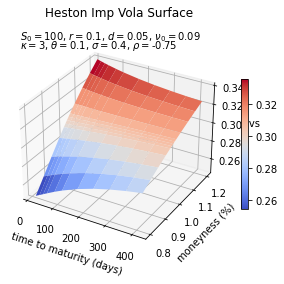

In [3]:
# Plot example of volatility surface
he_group = HestonGroup(first_date=ql.Date(1,1,2018), end_date=ql.Date(1,1,2018))
he_group.show_ivs(sp=100,ir=0.1,dr=0.05,v0=0.09,rho=-0.75,kappa=3,theta=0.1,sigma=0.4)

Here the calibration of the local volalility part of the SLV-model, i.e. the leverage function, starts. At first we load the historical observable and non observable parameters, compared to the calibrated parameters. Those are loaded from files generated by the notebook SLV-calib-stochastic.ipynb on the stochastic volatility calibration.

In [4]:
hist_params = load_dictionary(name_dict='he_hist_parameters')
hist_observable = load_dictionary(name_dict='he_observable')
cal_params = load_dictionary(name_dict='nn1_calibrated_params_he')
dates = sorted(hist_observable.keys())
# print(cal_params)
# print()
# print(hist_params)
# print()
# print(hist_observable)
# print()

In [5]:
df_orginal = {}
df_NN_untrained = {}
df_NN_trained = {}

for k in dates:
    S_0, ir, dr, nu_0 = hist_observable[k]
    kappa, theta, sigma, rho = hist_params[k]
    bat_obj_orginal = Heston_Model(model_dict=he_analytic, spot_price=S_0, 
                            risk_free_rate=ir, dividend_rate=dr,
                            inst_var=nu_0, calculation_date=ql.Date(8,11,2015),
                            expiration_dates_struct=delta_times, strike_struct=moneyness,
                            mean_rev_speed=kappa, eq_var=theta, vol_of_vol=sigma, 
                            correlation=rho)
    df_orginal[k] = bat_obj_orginal.df

    kappa, theta, sigma, rho = cal_params[k]
    bat_obj_NN_untrained = Heston_Model(model_dict=he_analytic, spot_price=S_0, 
                            risk_free_rate=ir, dividend_rate=dr,
                            inst_var=nu_0, calculation_date=ql.Date(8,11,2015),
                            expiration_dates_struct=delta_times, strike_struct=moneyness,
                            mean_rev_speed=kappa, eq_var=theta, vol_of_vol=sigma, 
                            correlation=rho)
    df_NN_untrained[k] = bat_obj_NN_untrained.df    
    
    bat_obj_NN_trained = Heston_Model(model_dict=he_analytic, spot_price=S_0, 
                            risk_free_rate=ir, dividend_rate=dr,
                            inst_var=nu_0, calculation_date=ql.Date(8,11,2015),
                            expiration_dates_struct=delta_times, strike_struct=moneyness,
                            mean_rev_speed=kappa, eq_var=theta, vol_of_vol=sigma, 
                            correlation=rho)
    df_NN_trained[k] = bat_obj_NN_trained.df   


<ipython-input-2-c70cf9a58e0d>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  new_array = np.array((ttm_days,strikes))


In the following we exemplarily test the proposed calibration scheme of the local volatility for five trading days.

In [6]:
m = 10 # layer dimension
n = 2 # number of layers for local volatility


N = len(delta_times)
N_money = len(moneyness)
T = 420

strikes = {date: df_orginal[date]['strikes'][:13] for date in dates}
discretization = 15 # in days
steps = int(420/discretization)
dt_2 = 1/steps

delta_times_adj = [int(t/discretization) for t in delta_times]

In [7]:
# Loss function and correlated Brownian increment generator
# -----------------------------------------------------------------------------  

def custom_loss(y_true,y_pred):
    return K.mean((K.mean(y_pred,axis=0)-K.mean(y_true,axis=0))**2)

def correlated_BM(rho_var, t_sample):
    dW1 = []
    dW2 = []
    for k in range(t_sample):
#         alpha[k][0] = alpha_0 # alpha_0
        dW1_h = np.random.normal(0, np.sqrt(dt_2), steps)
        dW2_h = rho_var * dW1_h + np.sqrt(1 - rho_var **2) * np.random.normal(0, np.sqrt(dt_2), steps)
        dW1.append(dW1_h)
        dW2.append(dW2_h)
    return [dW1, dW2]

The network classes are defined. There are two architectures that can be compared, see documentation deep_calibration_SLV_model.pdf. The first architecture (rec) models the leverage function $L(t,S_t) = 1 + \mathcal{N}(t,S_t)$ by a neural network that is recurrently evaluated at each time-step. The second architecture (tnn) models the leverage function with an individual network for each time-step $L(t,S_t) = 1 + \mathcal{N}_t(S_t)$. The first architecture performs better, as discussed in the documentation deep_calibration_SLV_model.pdf.

In [8]:
class MC_NeuralNet_rec:
    def __init__(self, observable_params, heston_params, time_date):
        spot_price, ir, dr, nu_0 = observable_params
        kappa, theta, sigma, rho = heston_params
        self.spot_price = spot_price
        self.ir = ir
        self.dr = dr
        self.nu_0 = nu_0
        self.kappe = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.time_date = time_date
        self._create_network()

        self.history = None

    def _create_network(self):
        self.leverage = tf.keras.Sequential()
        self.leverage.add(tf.keras.Input(shape=(2,)))
        self.leverage.add(tf.keras.layers.Dense(
            m, activation='tanh', 
            kernel_initializer=initializers.zeros, 
            bias_initializer=initializers.zeros
            ))
        self.leverage.add(tf.keras.layers.Dense(
            m, activation='tanh', 
            kernel_initializer=initializers.zeros, 
            bias_initializer=initializers.zeros
            ))
        self.leverage.add(tf.keras.layers.Dense(1))
        
        t_point = Input(shape=(1,))
        price = Input(shape=(1,))
        nu = Input(shape=(1,))
        inputs = [t_point] + [price] + [nu]
        inputshelper = []
        pricekey = []
        volakey = []
        start = 0

        for i in range(N):
            for j in range(start, delta_times_adj[i]):
                dW1_h = Input(shape=(1,)) # BM increment
                dW2_h = Input(shape=(1,)) # stochvol increment
                inputs = inputs + [dW1_h]
                inputshelper = inputshelper + [dW2_h]
                price = price + (ir - dr)*price*dt_2 + tf.sqrt(tf.abs(nu))*price*dW1_h*(1 + self.leverage(tf.concat([t_point, price],-1)))  # lv_nn
                nu = nu + kappa*(theta - nu)*dt_2 + sigma*tf.sqrt(tf.abs(nu))*dW2_h
                t_point = t_point + 1/28
            for l in range(N_money):
                pricekey.append(
                    Lambda(lambda x : 0.5*(abs(x - strikes[self.time_date][l]) + x - strikes[self.time_date][l]))(price)
                    )
            start = delta_times_adj[i]

        inputs = inputs + inputshelper  #S_0, alpha_0, Bmincr for each time-step, stochvol-incr for each time-step
        pricekey = Concatenate()(pricekey)
        self.model = Model(inputs=inputs, outputs=pricekey)

    def compile(self):
        self.model.compile(
            optimizer='Adam', 
            loss=custom_loss
            )

    def train(self, x, y, epochs=20, batch_size=5*10**3, valid_split=0.0, verbose=True):
        self.compile()
        self.history = self.model.fit(
            x=x, y=y, epochs=epochs, verbose=verbose, 
            batch_size=batch_size, validation_split=valid_split
            )
#         self.model.summary()
    
    def predict(self, x):
        return self.model.predict(x)

    def plot_metrics(self, metrics = ['loss']):
        for metric in metrics:
            self._plot_one_metric(metric=metric)

    def _plot_one_metric(self, metric):
        train_metrics = self.history.history[metric]
        val_metrics = self.history.history['val_' + metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation ' + metric + ', ' + str(self.time_date)[:10])
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_" + metric, 'val_' + metric])
        plt.savefig(f'fig/{metric}'+str(self.time_date)[:10]+'_rec.pdf')
        plt.show()
    
class MC_NeuralNet_tnn:
    def __init__(self, observable_params, heston_params, time_date):
        spot_price, ir, dr, nu_0 = observable_params
        kappa, theta, sigma, rho = heston_params
        self.spot_price = spot_price
        self.ir = ir
        self.dr = dr
        self.nu_0 = nu_0
        self.kappe = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.time_date = time_date
        self._create_network()
        self.history = None

    def _create_network(self):
        self.layers = [] # locvol-layers, trainable for locvol-NN
        for j in range(28):
            self.layers.append([
                Dense(
                    m, activation='tanh', trainable=True,
#                     m, activation='relu', trainable=True,
                    kernel_initializer=initializers.zeros,
                    bias_initializer=initializers.zeros
                    ),
                Dense(
#                     1, activation='tanh', trainable=True,
                    1, trainable=True,
                    kernel_initializer=initializers.zeros,
                    bias_initializer=initializers.zeros
                    )
                ])
        
        price = Input(shape=(1,))
        nu = Input(shape=(1,))
        inputs = [price] + [nu] 
        inputshelper = []
        pricekey = []
        volakey = []
        start = 0

        for i in range(N):
            for j in range(start, delta_times_adj[i]):
                lv_nn = self.layers[j][0](price) # local-volatiliy neural network
                lv_nn = self.layers[j][1](lv_nn) # local-volatiliy neural network
                dW1_h = Input(shape=(1,)) # BM increment
                dW2_h = Input(shape=(1,)) # stochvol increment
                inputs = inputs + [dW1_h]
                inputshelper = inputshelper + [dW2_h]
                price = price + (ir - dr)*price*dt_2 + tf.sqrt(tf.abs(nu))*price*dW1_h*(1 + lv_nn)
                nu = nu + kappa*(theta - nu)*dt_2 + sigma*tf.sqrt(tf.abs(nu))*dW2_h
            for l in range(N_money):
                pricekey.append(
                    Lambda(lambda x : 0.5*(abs(x - strikes[self.time_date][l]) + x - strikes[self.time_date][l]))(price)
                    )
            start = delta_times_adj[i]

        inputs = inputs + inputshelper  #S_0, alpha_0, Bmincr for each time-step, stochvol-incr for each time-step
        pricekey = Concatenate()(pricekey)
        self.model = Model(inputs=inputs, outputs=pricekey)

    def compile(self):
        self.model.compile(
            optimizer='Adam', 
            loss=custom_loss
            )

    def train(self, x, y, epochs=20, batch_size=5*10**3, valid_split=0.0, verbose=True):
        self.compile()
        self.history = self.model.fit(
            x=x, y=y, epochs=epochs, verbose=verbose, 
            batch_size=batch_size, validation_split=valid_split
            )
#         self.model.summary()
    
    def predict(self, x):
        return self.model.predict(x)
    
    def leverage_function(self, T_index, S):
        return self.layers[T_index][1](self.layers[T_index][0](S))     

    def plot_metrics(self, metrics = ['loss']):
        for metric in metrics:
            self._plot_one_metric(metric=metric)

    def _plot_one_metric(self, metric):
        train_metrics = self.history.history[metric]
        val_metrics = self.history.history['val_' + metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation ' + metric + ', ' + str(self.time_date)[:10])
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_" + metric, 'val_' + metric])
        plt.savefig(f'fig/{metric}'+str(self.time_date)[:10]+'_tnn.pdf')
        plt.show()


Here for each day a separate network is generated. For each day we learn the leverage function by calibrating the network to the corresponding synthetic market prices. The networks are quite big, so their construction takes quite a while (construction times below).

In [9]:
models = {}

for k in dates:
    t = time.time()
    models[k] = MC_NeuralNet_rec(observable_params=hist_observable[k], heston_params=cal_params[k], time_date = k)
#     models[k] = MC_NeuralNet_tnn(observable_params=hist_observable[k], heston_params=cal_params[k], time_date = k)
    print(time.time() - t)

7.328261852264404
17.723553895950317
29.468458890914917
41.39490818977356
54.86294627189636


Above, the time to built the networks for each of the five exemplary days is given. Curiously, each network takes a longer time to be built then the one before. This behaviour is not fully understood at the moment.

Here a bit of data is generated for testing. The price surfaces of the networks with untrained leverage $L(t,S_t) = 1$ are compared to the original price surfaces from the Heston model.

In [10]:
# Parameter dictionaries for plotting later
# -----------------------------------------------------------------------------
obs_dict = {}
cal_params_dict = {}
hist_params_dict = {}
for k in dates:
    obs_str = [r'$S_0 = $', r'$r = $', r'$d = $', r'$\nu_0 = $']
    params_str = [r'$\kappa = $', r'$\theta = $', r'$\sigma = $', r'$\rho = $']
    obs_dict[k] = ["{}{:.6}".format(o, str(v)) for o,v in zip(obs_str, list(hist_observable[k]))]
    cal_params_dict[k] = ["{}{:.5}".format(o, str(v)) for o,v in zip(params_str, list(cal_params[k]))]
    hist_params_dict[k] = ["{}{:.5}".format(o, str(v)) for o,v in zip(params_str, list(hist_params[k]))]

# Generation of test data
# -----------------------------------------------------------------------------

Ltest = 10**4
xtest = {}
ytest = {}

# Test data for rec network
# -----------------------------------------------------------------------------
for k in dates:
    rho = cal_params[k][3]
    spot_price = hist_observable[k][0]
    nu_0 = hist_observable[k][3]

    sv_proc = correlated_BM(rho, Ltest)
    xtest[k] = ([np.zeros(Ltest)] + [spot_price*np.ones(Ltest)] + [nu_0*np.ones(Ltest)] + [np.asarray([sv_proc[0][s][t] for s in range(Ltest)]) for t in range(steps)] +
          [np.asarray([sv_proc[1][s][t] for s in range(Ltest)]) for t in range(steps)])

    ytest[k] = np.zeros((Ltest,len(df_orginal[k]['price'])))
    for i in range(Ltest):
        ytest[k][i] = np.asarray(df_orginal[k]['price'])

# # Test data for tnn network
# # -----------------------------------------------------------------------------
# for k in dates:
#     rho = cal_params[k][3]
#     spot_price = hist_observable[k][0]
#     nu_0 = hist_observable[k][3]

#     sv_proc = correlated_BM(rho, Ltest)
#     xtest[k] = ([spot_price*np.ones(Ltest)] + [nu_0*np.ones(Ltest)] + [np.asarray([sv_proc[0][s][t] for s in range(Ltest)]) for t in range(steps)] +
#           [np.asarray([sv_proc[1][s][t] for s in range(Ltest)]) for t in range(steps)])

#     ytest[k] = np.zeros((Ltest,len(df_orginal[k]['price'])))
#     for i in range(Ltest):
#         ytest[k][i] = np.asarray(df_orginal[k]['price'])    
    

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


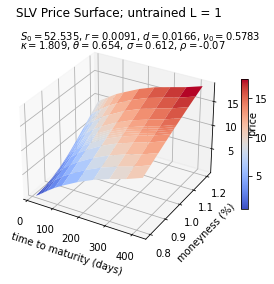

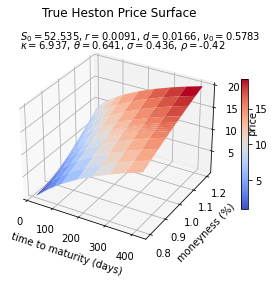

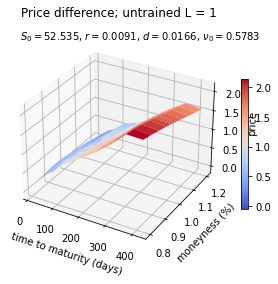

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


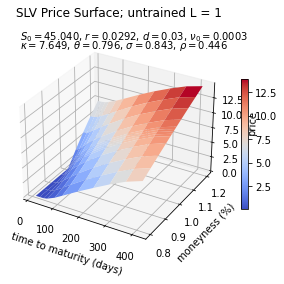

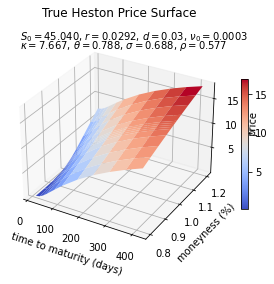

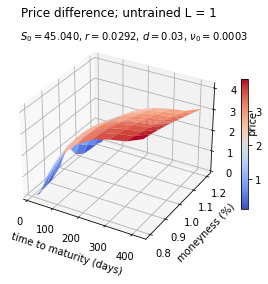

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


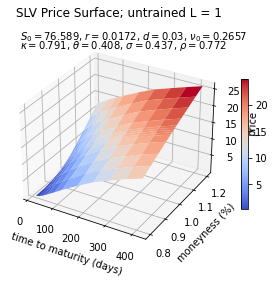

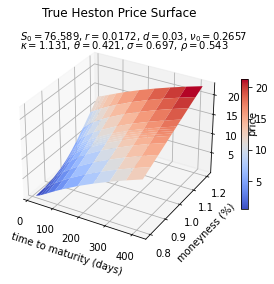

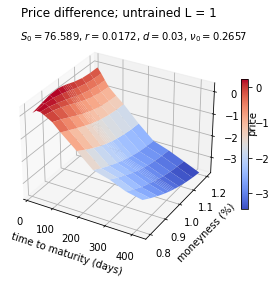

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


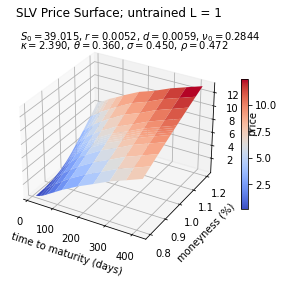

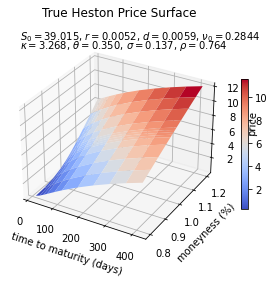

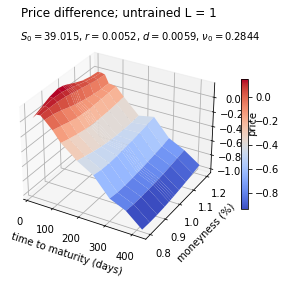

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


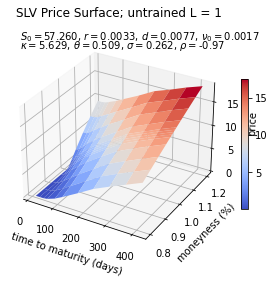

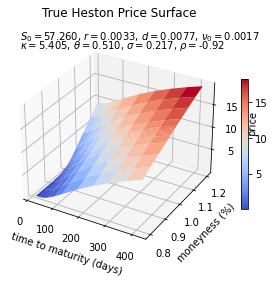

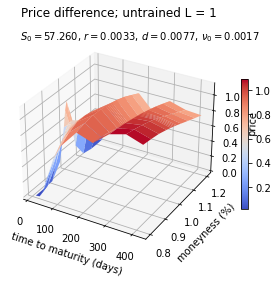

In [11]:
# Testing the untrained network
# -----------------------------------------------------------------------------
prediction_without_training = {}
for k in dates:
    prediction_without_training[k] = np.mean(models[k].predict(xtest[k]), axis=0)

    fig = plot_surface(
        Z=np.array(prediction_without_training[k]), 
        z_label='price', 
        main_title='SLV Price Surface; untrained L = 1',
        string1=', '.join(o for o in obs_dict[k]), 
        string2=', '.join(p for p in cal_params_dict[k])    
        )
    fig.savefig('fig/Psurf_'+'untrained_'+str(k)[:10]+'.pdf', transparent=True, dpi=100)

    fig = plot_surface(
        Z=np.array(df_orginal[k]['price']), 
        z_label='price', 
        main_title='True Heston Price Surface',
        string1=', '.join(o for o in obs_dict[k]), 
        string2=', '.join(p for p in hist_params_dict[k])      
        )
    fig.savefig('fig/Psurf_'+'orginal_'+str(k)[:10]+'.pdf', transparent=True, dpi=100)

    fig = plot_surface(
        Z=np.array(df_orginal[k]['price'])-np.array(prediction_without_training[k]), 
        z_label='price', 
        main_title='Price difference; untrained L = 1',
        string1=', '.join(o for o in obs_dict[k])      
        )
    fig.savefig('fig/Psurf_'+'untrained_diff_'+str(k)[:10]+'.pdf', transparent=True, dpi=100)


One sees that there are deviations between the original price surfaces and the ones generated with the networks. These deviations are systematic and result from a constant shift with respect to the orignal price surface (the difference plots are all positive). This is expected, since the true prices are calculated from the true historical Heston parameters (indicated in the plots), while network uses the (distinct) calibrated parameters (from the stochastic volatility calibration) to price the options. In this implementation the leverage function is directly included as deep network, which allows us to train it to market data (respectively synthetic data, here). We will see that the training smoothens out the price surface and reduces the difference to the original data. This shows the potential of this approach to obtain a suitable fit to real observed market data.

In the following the calibration/training takes place with a larger data set as in the testing scenario. Note that a relatively small data set ($\sim10^5$) and large batch-size ($\sim10^4$) is suitable in the here considered calibration scheme.

In [12]:
Ltrain = 10**5

xtrain = {}
ytrain = {}

# Training data for rec network
# -----------------------------------------------------------------------------
for k in dates:
    rho = cal_params[k][3]
    spot_price = hist_observable[k][0]
    nu_0 = hist_observable[k][3]

    sv_proc = correlated_BM(rho, Ltrain)
    xtrain[k] = ([np.zeros(Ltrain)] + [spot_price*np.ones(Ltrain)] + [nu_0*np.ones(Ltrain)] + [np.asarray([sv_proc[0][s][t] for s in range(Ltrain)]) for t in range(steps)] +
          [np.asarray([sv_proc[1][s][t] for s in range(Ltrain)]) for t in range(steps)])

    ytrain[k] = np.zeros((Ltrain,len(df_orginal[k]['price'])))
    for i in range(Ltrain):
        ytrain[k][i] = np.asarray(df_orginal[k]['price'])
        
# # Training data for tnn network
# # -----------------------------------------------------------------------------
# for k in dates:
#     rho = cal_params[k][3]
#     spot_price = hist_observable[k][0]
#     nu_0 = hist_observable[k][3]

#     sv_proc = correlated_BM(rho, Ltrain)
#     xtrain[k] = ([spot_price*np.ones(Ltrain)] + [nu_0*np.ones(Ltrain)] + [np.asarray([sv_proc[0][s][t] for s in range(Ltrain)]) for t in range(steps)] +
#           [np.asarray([sv_proc[1][s][t] for s in range(Ltrain)]) for t in range(steps)])

#     ytrain[k] = np.zeros((Ltrain,len(df_orginal[k]['price'])))
#     for i in range(Ltrain):
#         ytrain[k][i] = np.asarray(df_orginal[k]['price'])
        

In [13]:
for k in dates:
    t = time.time()
    models[k].train(x=xtrain[k], y=ytrain[k], epochs=50, batch_size=10**4, valid_split=0.2, verbose=0)
    print('training time: ', time.time() - t)

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


training time:  64.24649596214294
training time:  64.64665174484253
training time:  64.8698091506958
training time:  65.90988993644714
training time:  66.73910188674927


Plotting the training and validation loss.

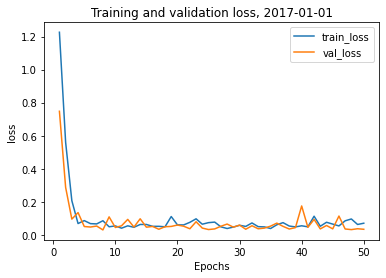

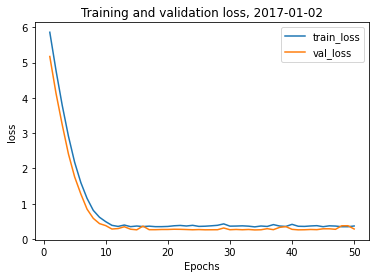

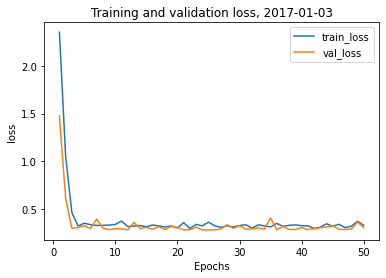

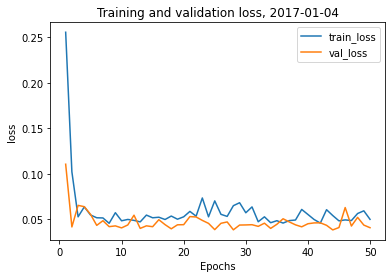

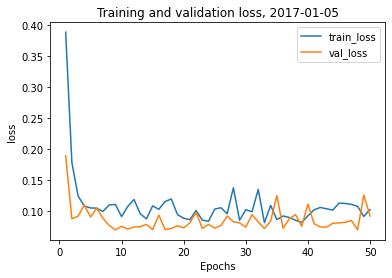

In [14]:
for k in dates:
    models[k].plot_metrics()

The trained network is tested:

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


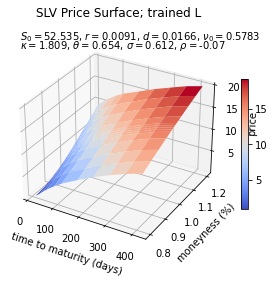

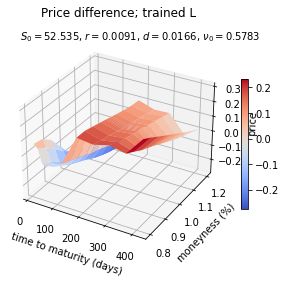

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


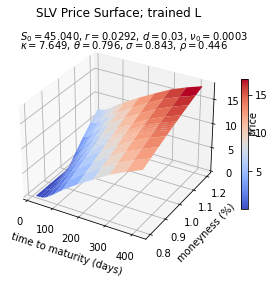

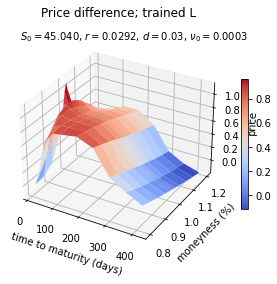

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


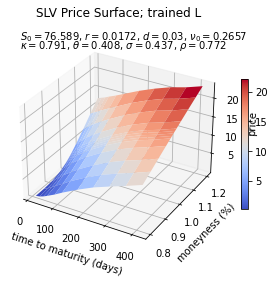

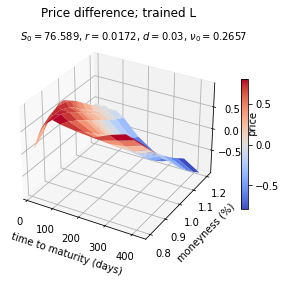

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


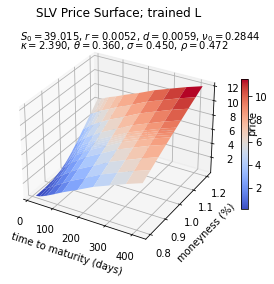

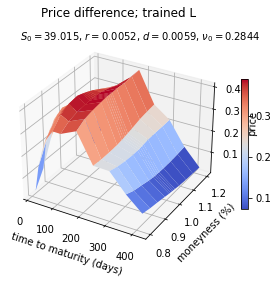

/Users/ericbrunner/.pyenv/versions/3.8.0/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


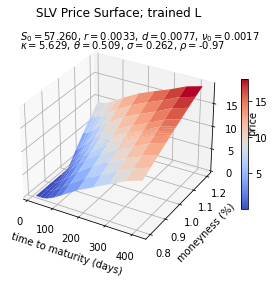

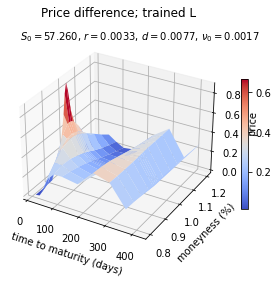

In [15]:
# Testing the trained network
#------------------------------------------------------------------------------

Ltest = 10**4
xtest = {}
ytest = {}

# Test data for rec network
# -----------------------------------------------------------------------------
for k in dates:
    rho = cal_params[k][3]
    spot_price = hist_observable[k][0]
    nu_0 = hist_observable[k][3]

    sv_proc = correlated_BM(rho, Ltest)
    xtest[k] = ([np.zeros(Ltest)] + [spot_price*np.ones(Ltest)] + [nu_0*np.ones(Ltest)] + [np.asarray([sv_proc[0][s][t] for s in range(Ltest)]) for t in range(steps)] +
          [np.asarray([sv_proc[1][s][t] for s in range(Ltest)]) for t in range(steps)])

    ytest[k] = np.zeros((Ltest,len(df_orginal[k]['price'])))
    for i in range(Ltest):
        ytest[k][i] = np.asarray(df_orginal[k]['price'])
        
# # Test data for tnn network
# # -----------------------------------------------------------------------------
# for k in dates:
#     rho = cal_params[k][3]
#     spot_price = hist_observable[k][0]
#     nu_0 = hist_observable[k][3]

#     sv_proc = correlated_BM(rho, Ltest)
#     xtest[k] = ([spot_price*np.ones(Ltest)] + [nu_0*np.ones(Ltest)] + [np.asarray([sv_proc[0][s][t] for s in range(Ltest)]) for t in range(steps)] +
#           [np.asarray([sv_proc[1][s][t] for s in range(Ltest)]) for t in range(steps)])

#     ytest[k] = np.zeros((Ltest,len(df_orginal[k]['price'])))
#     for i in range(Ltest):
#         ytest[k][i] = np.asarray(df_orginal[k]['price'])    

prediction_with_training = {}

for k in dates:
    prediction_with_training[k] = np.mean(models[k].predict(xtest[k]), axis=0)

    fig = plot_surface(
        Z=np.array(prediction_with_training[k]), 
        z_label='price', 
        main_title='SLV Price Surface; trained L',
        string1=', '.join(o for o in obs_dict[k]), 
        string2=', '.join(p for p in cal_params_dict[k])    
        )

    fig.savefig('fig/Psurf_'+'trained_'+str(k)[:10]+'.pdf', transparent=True, dpi=100)
    
    fig = plot_surface(
        Z=np.array(df_orginal[k]['price'])-np.array(prediction_with_training[k]), 
        z_label='price', 
        main_title='Price difference; trained L',
        string1=', '.join(o for o in obs_dict[k])   
        )
    
    fig.savefig('fig/Psurf_'+'trained_diff_'+str(k)[:10]+'.pdf', transparent=True, dpi=100)


Comparing the difference surfaces before and after training, one sees a significant improvement in terms of the fit. The deviations from the original price surfaces are about one order of magnitude smaller then without training. The constant shift (bias) from the original data is compensated for. 